# Ages and Masses from GALAH Spectra with The Cannon

## Part 2: Training and testing The Cannon

In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.io import fits
import numpy as np
from astropy.table import Table, join
from scipy.io.idl import readsav
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import pickle
import thecannon as tc

# Reading in all important information for The Cannon

We have spectra with P pixels.
We have S training set stars
We have L labels

What we need:

labels : tuple([label1, label2, label3, ..., labelL]) of SxL pixels

wavelength_array : array with P pixels

training_set_flux : array with PxS pixels

training_set_ivar : array with PxS pixels

In [2]:
# Setting up the labels

trainingset = Table.read('trainingset.fits')
# In case we come back to this after a long break: Pring what training set labels are actually available
print(trainingset.keys())

labels = tuple(['teff', 'logg', 'fe_h', 'mass'])

training_set_labels = Table()
for label in labels:
    training_set_labels[label] = trainingset[label]

['sobject_id', 'teff', 'logg', 'fe_h', 'alpha_fe', 'nu_max', 'delta_nu', 'mass', 'age', 'mass_astero', 'j_m', 'h_m', 'ks_m']


In [3]:
# Setting up the wavelength
wavelength_array = np.loadtxt('wavelength.txt')

In [4]:
# Setting up the flux and ivar arrays
flux_ivar_file_opener = open('trainingset_flux_ivar.pickle','rb')
training_set_flux,training_set_ivar = pickle.load(flux_ivar_file_opener)
flux_ivar_file_opener.close()

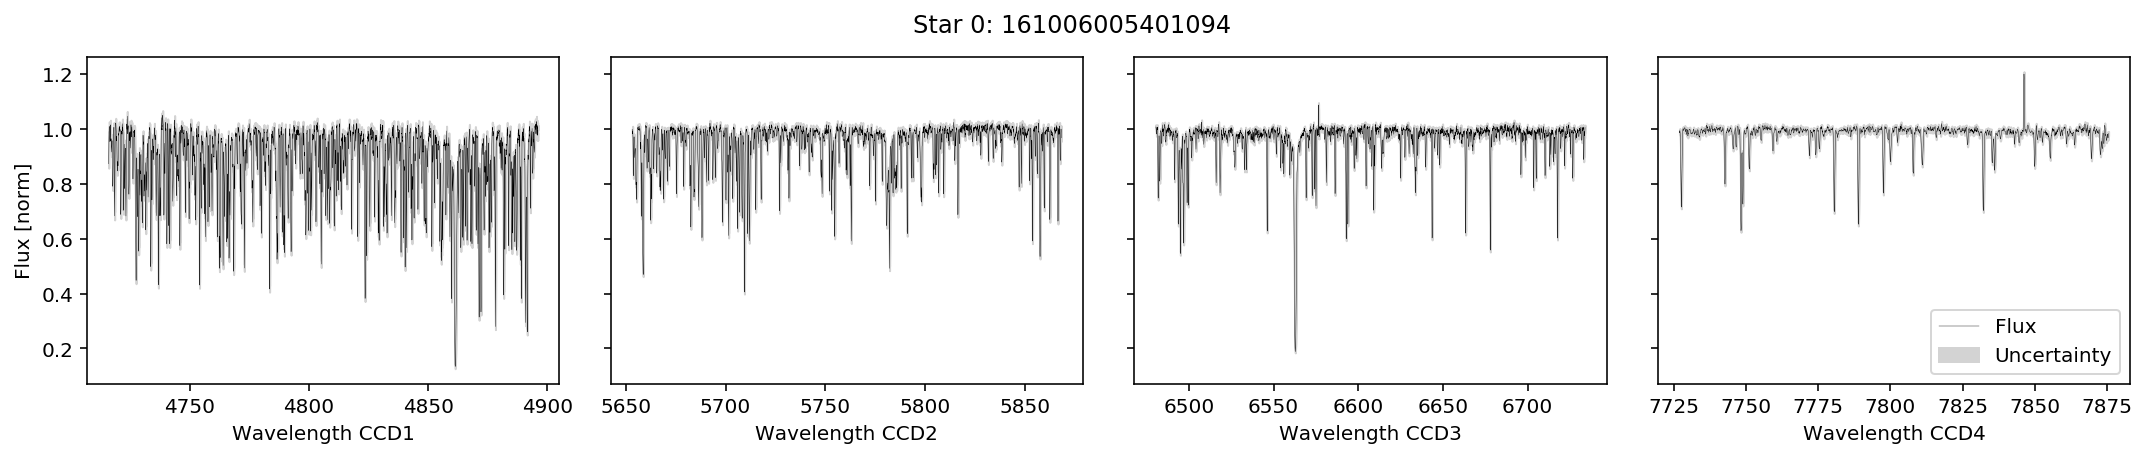

In [5]:
# Here we can simply plot a training set spectrum to see if it is good or should be rejected
# remember: ivar = 1/uncertainty**2 -> uncertainty == sqrt(1/ivar)

def plot_training_set_spectrum(index, ccds=[1,2,3,4]):
    
    f, gs = plt.subplots(1,len(ccds),figsize=(15,3),sharey=True)
    plt.suptitle('Star '+str(index)+': '+str(trainingset['sobject_id'][index]),x=0.5,y=1.05)
    
    for ccd in ccds:
        ax=gs[ccd-1]
        
        in_wavelength_range = (wavelength_array >= (3+ccd)*1000) & (wavelength_array <= (4+ccd)*1000)

        ax.fill_between(
            wavelength_array[in_wavelength_range],
            training_set_flux[index,in_wavelength_range]-np.sqrt(1/training_set_ivar[index,in_wavelength_range]),
            training_set_flux[index,in_wavelength_range]+np.sqrt(1/training_set_ivar[index,in_wavelength_range]),
            color='lightgrey',label='Uncertainty'
        )
        
        ax.plot(
            wavelength_array[in_wavelength_range],
            training_set_flux[index,in_wavelength_range],
            lw=0.2,c='k',label='Flux'
        )
        
        ax.set_xlabel('Wavelength CCD'+str(ccd))
        
        if ccd == 1:
            ax.set_ylabel('Flux [norm]')
        if ccd == 4:
            ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()
    plt.close()

plot_training_set_spectrum(0)

# Setting up, Training, and Testing The Cannon

In [6]:
# We can use a linear, quadratic, etc. model. A quadratic one has order 2
order = 2

# Because we might want to play around with the labels that we train on, let's put the used labels into the model name
model_file = 'galah_age_mass_model_order'+str(order)+'_'+"_".join(labels)

# Now if we have already trained the Cannon, we can simply read in the existing Model
try:
    model = tc.CannonModel.read(model_file+'.model')
except:
    # There is no CannonModel available yet
    # Let's setup the Cannon model.
    model = tc.CannonModel(
        training_set_labels, training_set_flux, training_set_ivar,
        vectorizer=tc.vectorizer.PolynomialVectorizer(labels, order),dispersion=wavelength_array)

In [7]:
# This is where the magic happens! We train the Cannon (if it is not yet trained)! 

# This will start with several "red" messages. 
# A common warning is "Optimization warning (l_bfgs_b): b'ABNORMAL_TERMINATION_IN_LNSRCH"
# Don't panic - that just means it will take a different optimisation algorithm than the default one.

if not model.is_trained:
    print('Training The Cannon')
    theta, s2, metadata = model.train(threads=1)
    
    # Now that the magic is done, let's save the result
    model.write(model_file+'.model',overwrite=True)
else:
    print('The Cannon is already trained')
    
# Now let's run the Cannon on its own training set to estimate labels and uncertainties
print('Testing The Cannon')
test_labels, cov, metadata = model.test(training_set_flux, training_set_ivar)

The Cannon is already trained
Testing The Cannon


2022-02-04 10:55:05,581 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2022-02-04 10:55:05,582 [INFO] Running test step on 875 spectra


[=============================================================================================================] 100% (31s)                              


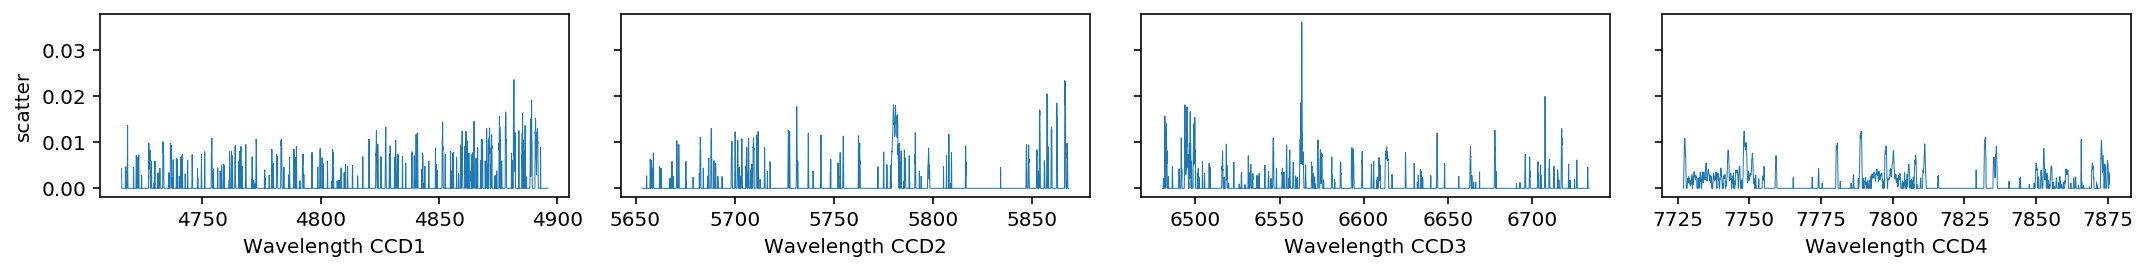

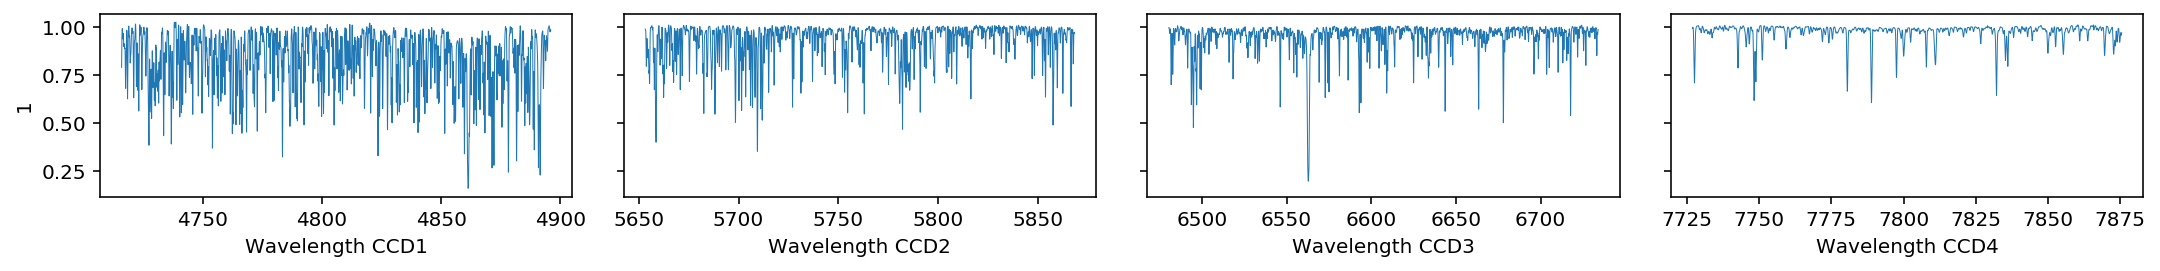

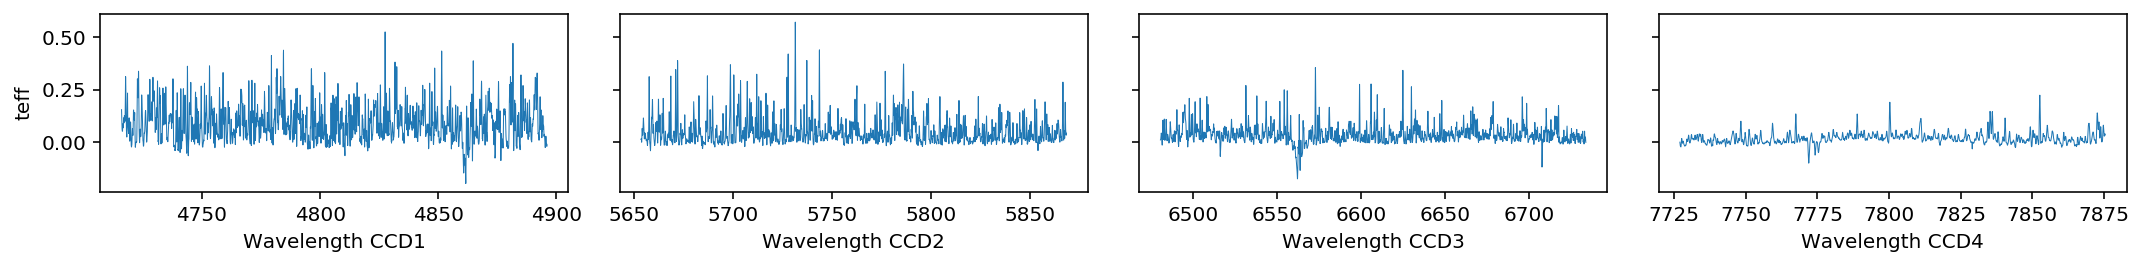

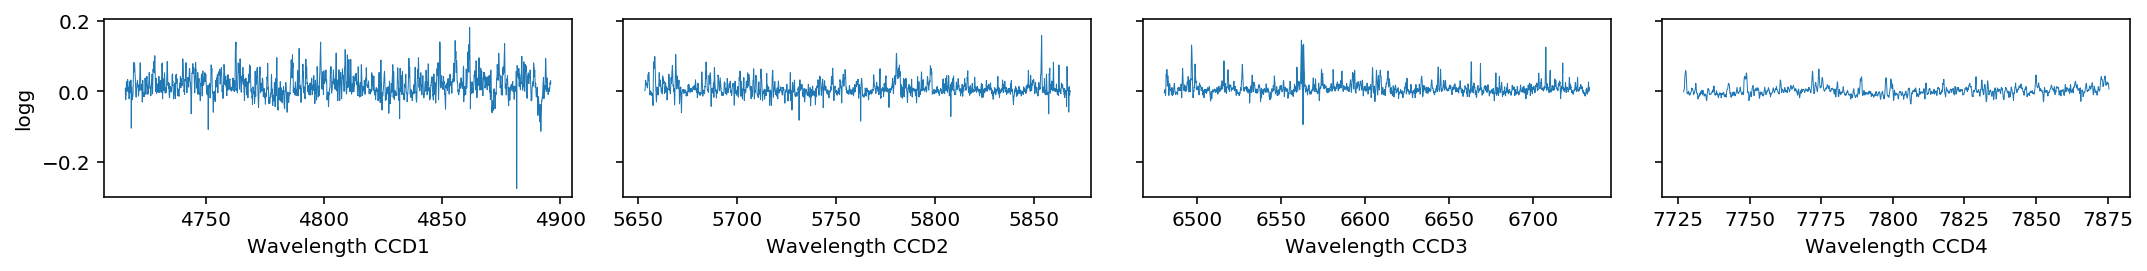

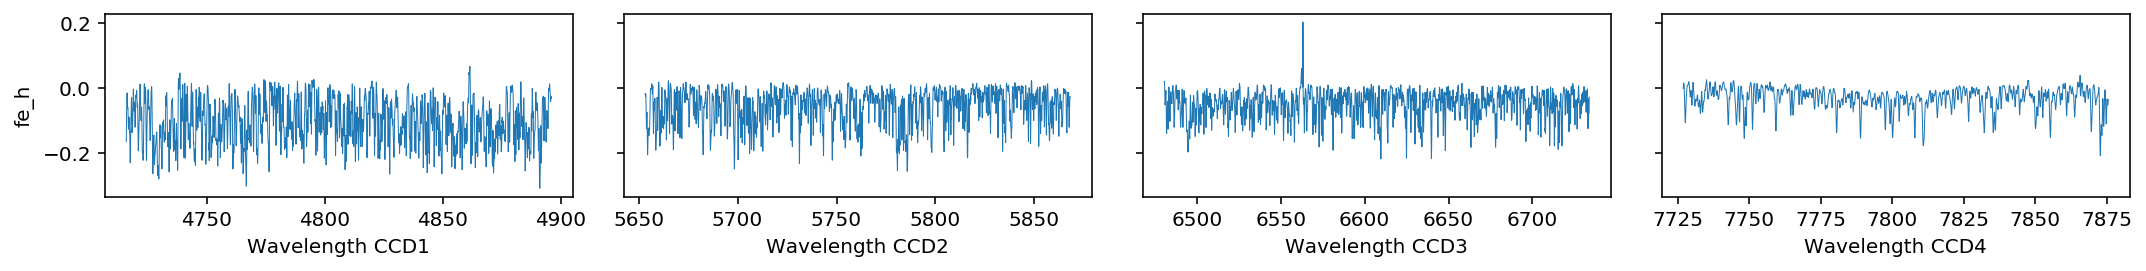

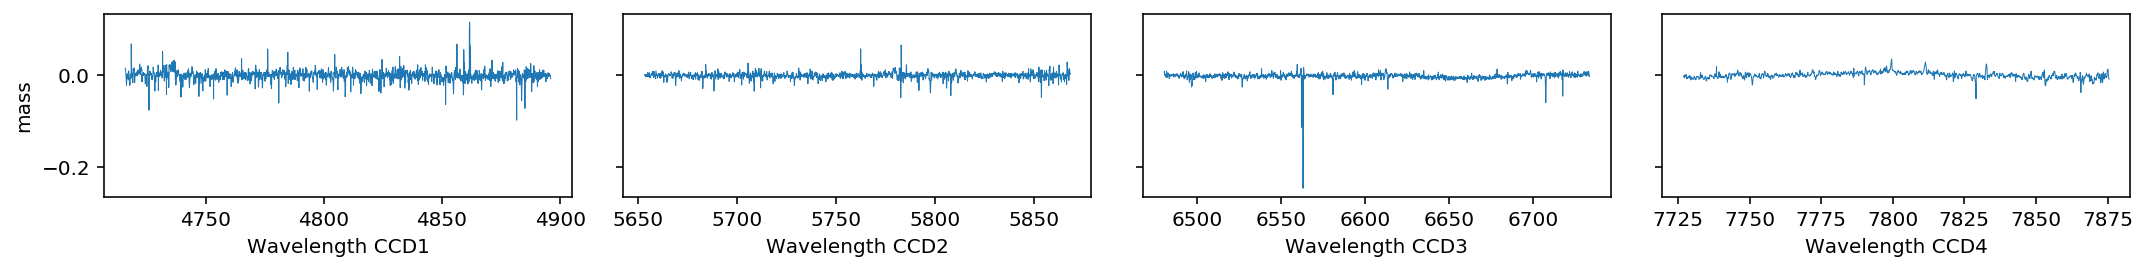

In [8]:
# Now let's plot some of the coefficients to get an idea, which pixels the model considers interesting.
# Because we have 4 different CCDs, let's plot them next to each other and neglect the gaps.

def plot_coefficients(model, index, ccds=[1,2,3,4]):
    
    # let's have an option to plot the scatter with a negative index
    if index == -1:
        ylabel = 'scatter'
    else:
        ylabel = model.vectorizer.get_human_readable_label_term(index,
                label_names = model.vectorizer.label_names, mul='\cdot', pow='^')
        
    f, gs = plt.subplots(1,len(ccds),figsize=(15,2),sharey=True)
    
    for ccd in ccds:
        ax=gs[ccd-1]
        
        in_wavelength_range = (wavelength_array >= (3+ccd)*1000) & (wavelength_array <= (4+ccd)*1000)

        # The Cannon Model also knows where it is not well trained.
        # This is saved in the "model.s2" and can be shown as scatter
        if index == -1:
            ax.plot(
                wavelength_array[in_wavelength_range],
                model.s2[in_wavelength_range]**0.5,
                lw=0.5,c='C0'
            )
            #ax.set_ylim(0,0.1)
        else:
            ax.plot(
                wavelength_array[in_wavelength_range],
                model.theta[in_wavelength_range,index],
                lw=0.5,c='C0',label='TheCannon'
            )
        ax.set_xlabel('Wavelength CCD'+str(ccd))

        if ccd==1:
            ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.savefig('coefficient_plots/coeff_'+model_file+'_'+ylabel+'.png',dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()

#for index in range(-1,np.shape(model.theta)[1]):
for index in range(-1,len(labels)+1):
    plot_coefficients(model, index, ccds=[1,2,3,4])

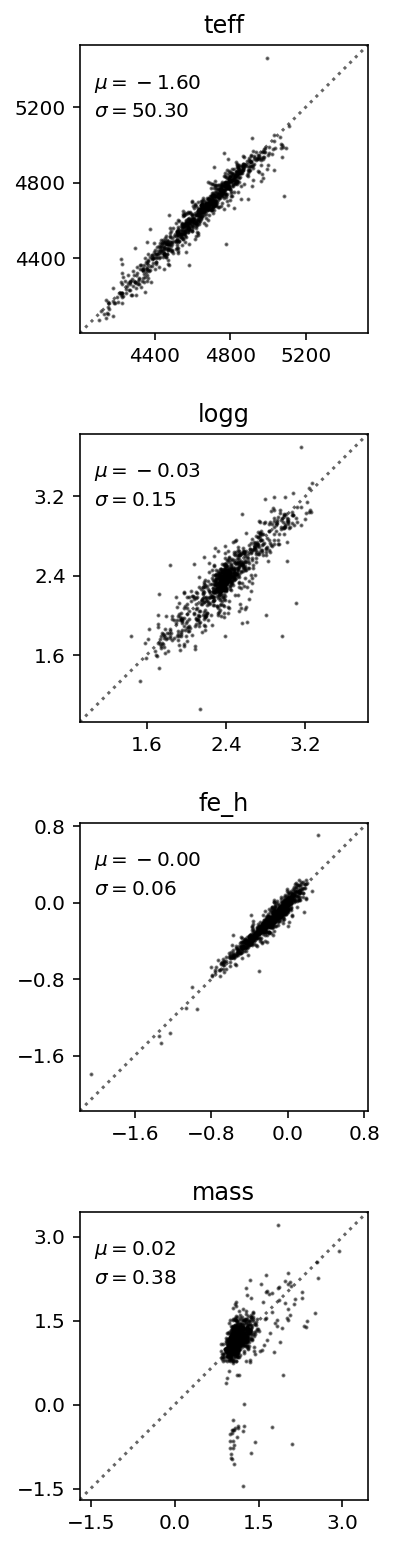

In [9]:
fig_comparison = tc.plot.one_to_one(model, test_labels)
fig_comparison.savefig('1on1_plots/1on1_'+model_file+'.png',dpi=200,bbox_inches='tight')